Mock-up, what does this notebook do? 

load a catalog, plot HOD of high and low conc halos on the same plot
load model, plot prediction for high and low conc halos 

In [127]:
import numpy as np
import astropy
from itertools import izip
from pearce.mocks import compute_prim_haloprop_bins, cat_dict
from pearce.mocks.customHODModels import *
from halotools.utils.table_utils import compute_conditional_percentiles
from halotools.mock_observables import hod_from_mock

In [128]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [129]:
mag_cut = -21
min_ptcl = 200
#mass_key ='halo_mvir'
mag_key = 'halo_vpeak_mag'
upid_key = 'halo_upid'

In [130]:
PMASS = 591421440.0000001 #chinchilla 400/ 2048
#catalog = np.loadtxt('ab_sham_hod_data_cut.npy')
catalog = astropy.table.Table.read('abmatched_halos.hdf5', format = 'hdf5')

In [131]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[0.658, 1.0]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(1.0)
halo_masses = cat.halocat.halo_table['halo_mvir']

In [132]:
halo_catalog = catalog[np.logical_and(catalog['halo_mvir'] > min_ptcl*cat.pmass, catalog[mag_key] <=mag_cut)]

In [133]:
#MAP = np.array([ 0.13739522, -0.4908254 , 2.00000001,  1.22465894])
#MAP = np.array([ 0.38800666, -0.49540832, 3, 3])
MAP = np.array([ 1.0, -0.5,10.0,10.0])
names = ['mean_occupation_centrals_assembias_param1','mean_occupation_satellites_assembias_param1',\
        'mean_occupation_centrals_assembias_slope1','mean_occupation_satellites_assembias_slope1']
params = dict(zip(names, MAP))

In [134]:
from math import ceil
def compute_mass_bins(prim_haloprop, dlog10_prim_haloprop=0.05):   
    lg10_min_prim_haloprop = np.log10(np.min(prim_haloprop))-0.001
    lg10_max_prim_haloprop = np.log10(np.max(prim_haloprop))+0.001
    num_prim_haloprop_bins = (lg10_max_prim_haloprop-lg10_min_prim_haloprop)/dlog10_prim_haloprop
    return np.logspace(
        lg10_min_prim_haloprop, lg10_max_prim_haloprop,
        num=int(ceil(num_prim_haloprop_bins)))

In [135]:
from collections import Counter
def compute_occupations(halo_table, halo_catalog):
    #halo_table = cat.halocat.halo_table[cat.halocat.halo_table['halo_mvir'] > min_ptcl*cat.pmass]

    cens_occ = np.zeros((np.sum(halo_table[upid_key] == -1),))
    #cens_occ = np.zeros((len(halo_table),))
    sats_occ = np.zeros_like(cens_occ)
    detected_central_ids = set(halo_catalog[halo_catalog[upid_key]==-1]['halo_id'])
    detected_satellite_upids = Counter(halo_catalog[halo_catalog[upid_key]!=-1][upid_key])
    
    for idx, row  in enumerate(halo_table[halo_table[upid_key] == -1]):
        cens_occ[idx] = 1.0 if row['halo_id'] in detected_central_ids else 0.0
        sats_occ[idx]+= detected_satellite_upids[row['halo_id']]

    return cens_occ, sats_occ

In [136]:
def compute_hod(masses, cens_occ, sats_occ, mass_bins):
    mb_nos = compute_prim_haloprop_bins(prim_haloprop = masses, prim_haloprop_bin_boundaries = mass_bins)
    cen_hod = np.zeros((mass_bins.shape[0]-1,))
    sat_hod = np.zeros((mass_bins.shape[0]-1,))
    for i, mb in  enumerate(np.unique(mb_nos)):
        idx_in_bin = np.where(mb_nos == mb)[0]
        cen_hod[i] = np.sum(cens_occ[idx_in_bin])/float(len(idx_in_bin))
        sat_hod[i] = np.sum(sats_occ[idx_in_bin])/float(len(idx_in_bin))
        
    return cen_hod, sat_hod

In [137]:
len(catalog)

1857085

In [138]:
catalog = np.zeros((np.sum(halo_table[upid_key]==-1), 6))
catalog[:,3] = halo_table[halo_table[upid_key]==-1]['halo_mvir']
catalog[:,1] = cens_occ
catalog[:,2] = sats_occ
catalog[:,5] = halo_table[halo_table[upid_key]==-1]['halo_nfw_conc']
#catalog[:,5] = halo_table[halo_table[upid_key]==-1]['halo_vpeak']

In [139]:
mass_bins = compute_mass_bins(halo_table['halo_mvir'], 0.1)
mbc = (mass_bins[1:]+mass_bins[:-1])/2.0

In [140]:
cen_hod,sat_hod = compute_hod(catalog[:,3], catalog[:,1], catalog[:,2],  mass_bins)

In [141]:
np.savetxt('tabulated_cen_hod.npy', cen_hod)
np.savetxt('tabulated_sat_hod.npy', sat_hod)
np.savetxt('tabulated_mbc.npy', mbc)

In [142]:
from pearce.mocks.customHODModels import *

In [143]:
cat.load_model(1.0, HOD=(HSAssembiasTabulatedCens, HSAssembiasTabulatedSats), hod_kwargs = {'prim_haloprop_vals': mbc,
                                                                #'sec_haloprop_key':'halo_vpeak',
                                                                'cen_hod_vals':cen_hod,
                                                               'sat_hod_vals':sat_hod,
                                                                'split':0.7})

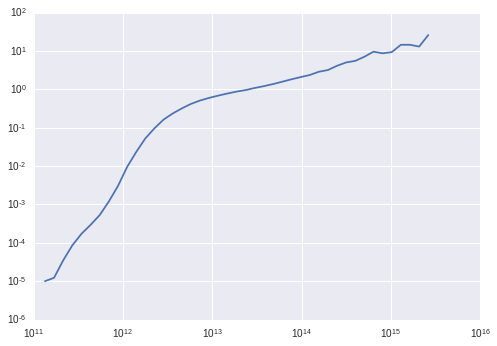

In [144]:
plt.plot(mbc, cen_hod+ sat_hod)
plt.loglog();

In [145]:
cat.populate(params);

In [146]:
cat.model.param_dict

{'mean_occupation_centrals_assembias_param1': 1.0,
 'mean_occupation_centrals_assembias_slope1': 10.0,
 'mean_occupation_satellites_assembias_param1': -0.5,
 'mean_occupation_satellites_assembias_slope1': 10.0}

In [147]:
mock_masses= cat.model.mock.halo_table['halo_mvir']
mock_centrals =cat.model.mock.halo_table['halo_num_centrals']
mock_satellites = cat.model.mock.halo_table['halo_num_satellites']
mock_cen_hod, mock_sat_hod = compute_hod(mock_masses, mock_centrals, mock_satellites, mass_bins)

In [148]:
mass_bin_centers = (mass_bins[1:]+mass_bins[:-1])/2.0

(0.001, 30)

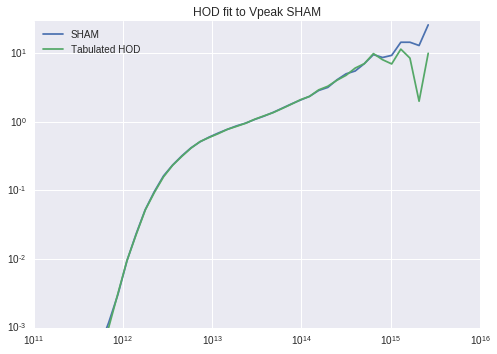

In [149]:
plt.plot(mass_bin_centers,cen_hod+sat_hod, label = 'SHAM')
plt.plot(mass_bin_centers,mock_cen_hod+mock_sat_hod, label = 'Tabulated HOD')
plt.loglog()
plt.title('HOD fit to Vpeak SHAM')
plt.legend(loc='best')
plt.ylim([1e-3, 30]);
#plt.yscale('log')

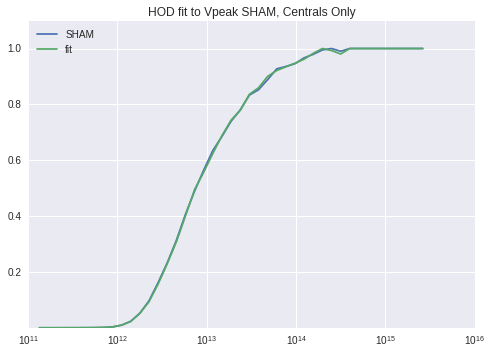

In [150]:
plt.plot(mass_bin_centers,cen_hod, label = 'SHAM')
plt.plot(mass_bin_centers,mock_cen_hod, label = 'fit')
#plt.loglog()
plt.title('HOD fit to Vpeak SHAM, Centrals Only')
plt.legend(loc='best')
plt.ylim([1e-3, 1.1]);
plt.xscale('log')

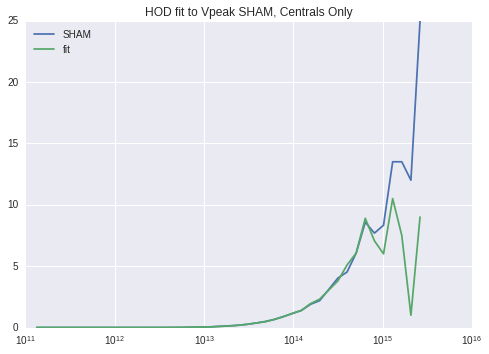

In [151]:
plt.plot(mass_bin_centers,sat_hod, label = 'SHAM')
plt.plot(mass_bin_centers,mock_sat_hod, label = 'fit')
plt.title('HOD fit to Vpeak SHAM, Centrals Only')
plt.legend(loc='best')
#plt.ylim([1e-3, 1.1]);
plt.xscale('log')

In [152]:
percentiles = compute_conditional_percentiles(prim_haloprop = catalog[:,3], sec_haloprop = catalog[:,5],
                                              prim_haloprop_bin_boundaries= mass_bins)

In [153]:
low_conc_halos = percentiles < 0.5 

low_cen_hod, low_sat_hod = compute_hod(catalog[low_conc_halos, 3],catalog[low_conc_halos,1], catalog[low_conc_halos,2],mass_bins)
high_cen_hod, high_sat_hod =compute_hod(catalog[~low_conc_halos,3],catalog[~low_conc_halos,1], catalog[~low_conc_halos,2],mass_bins)

In [154]:
mock_percentiles = compute_conditional_percentiles(prim_haloprop = mock_masses,
                                                   sec_haloprop = cat.model.mock.halo_table['halo_nfw_conc'],
                                                   #sec_haloprop = cat.model.mock.halo_table['halo_vpeak'],
                                              prim_haloprop_bin_boundaries= mass_bins)

In [155]:
low_conc_mock_halos = mock_percentiles <= 0.5


low_mock_cen_hod, low_mock_sat_hod = compute_hod(mock_masses[low_conc_mock_halos],
                                   mock_centrals[low_conc_mock_halos], mock_satellites[low_conc_mock_halos],\
                                   mass_bins)

high_mock_cen_hod, high_mock_sat_hod = compute_hod(mock_masses[~low_conc_mock_halos],
                                   mock_centrals[~low_conc_mock_halos], mock_satellites[~low_conc_mock_halos],\
                                   mass_bins)


In [156]:
import numpy as np
from scipy.stats import poisson, rankdata
from halotools.empirical_models import noisy_percentile


def get_ranks(data):
    rank = rankdata(data, 'ordinal') - 0.5
    rank /= len(data)
    return rank


def shuffle_ranks(original_ranks, correlation):    
    if correlation >= 1.0:
        return original_ranks
    if correlation <= -1.0:
        return 1.0 - original_ranks
    
    positive_correlation = (correlation > 0)
    correlation_magnitude = abs(correlation)
    
    if correlation_magnitude < 1.0e-8:
        return get_ranks(np.random.rand(*original_ranks.shape))
    
    x = (1.0-correlation_magnitude)/correlation_magnitude    
    scale = (x**0.37 * (1.0+x**0.6) * 0.25)
    ranks = np.random.normal(loc=(original_ranks if positive_correlation else (-original_ranks)), scale=scale)
    
    return get_ranks(ranks)

def shuffle_ranks2(original_ranks, correlation):
    return noisy_percentile(original_ranks, correlation_coeff=correlation)


def get_cen_count(rank_conc, mean_n_cen, A_cen):
    new_rank = shuffle_ranks2(rank_conc, A_cen)
    return (new_rank >= mean_n_cen).astype(np.int)


def get_sat_count(rank_conc, mean_n_sat, A_sat):
    new_rank = shuffle_ranks(rank_conc, A_sat)
    return poisson.isf(1.0 - new_rank, mu=mean_n_sat)

In [157]:
yao_cens = np.zeros_like(cens_occ)
yao_sats = np.zeros_like(sats_occ)
mb_nos = compute_prim_haloprop_bins(prim_haloprop = catalog[:,3], prim_haloprop_bin_boundaries = mass_bins)

for i, (mb, ch, sh) in  enumerate(zip(np.unique(mb_nos), cen_hod, sat_hod)):
    idx_in_bin = np.where(mb_nos == mb)[0]
    rank_conc = get_ranks(catalog[idx_in_bin, 5])
    yao_cens[idx_in_bin] = 1.0-get_cen_count(rank_conc, ch, -0.6)
    yao_sats[idx_in_bin] = get_sat_count(rank_conc, sh, -0.6)

In [158]:
yao_cen_hod, yao_sat_hod = compute_hod(catalog[:,3], yao_cens, yao_sats, mass_bins)

In [159]:
low_yao_cen_hod, low_yao_sat_hod = compute_hod(catalog[low_conc_halos, 3],yao_cens[low_conc_halos], yao_sats[low_conc_halos],mass_bins)
high_yao_cen_hod, high_yao_sat_hod =compute_hod(catalog[~low_conc_halos,3],yao_cens[~low_conc_halos], yao_sats[~low_conc_halos],mass_bins)

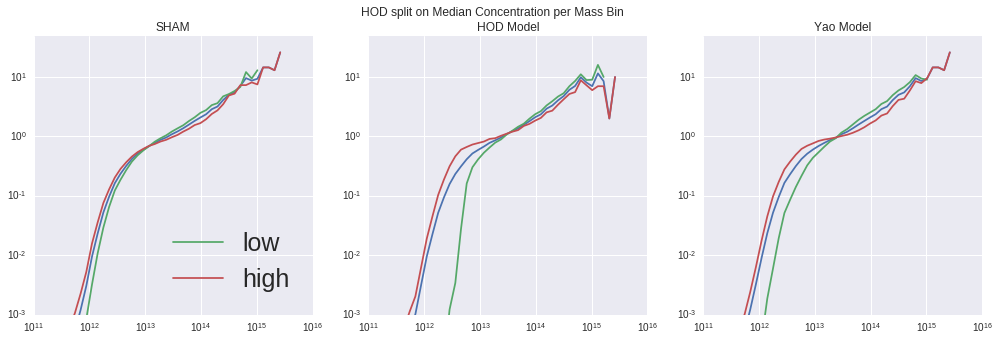

In [160]:
fig = plt.figure(figsize = (17,5))

plt.subplot(131)
plt.title('SHAM')
plt.plot(mass_bin_centers,cen_hod+sat_hod)
plt.plot(mass_bin_centers,low_cen_hod+low_sat_hod, label = 'low')
plt.plot(mass_bin_centers,high_cen_hod+high_sat_hod, label = 'high')

plt.legend(loc='best', fontsize = 25)
plt.loglog()
plt.ylim([1e-3,5e1])
plt.subplot(132)
plt.title('HOD Model')
plt.plot(mass_bin_centers,mock_cen_hod+mock_sat_hod)
plt.plot(mass_bin_centers,low_mock_cen_hod+low_mock_sat_hod, label = 'low')
plt.plot(mass_bin_centers,high_mock_cen_hod+high_mock_sat_hod, label = 'high')
plt.loglog()
plt.ylim([1e-3,5e1])
plt.subplot(133)
plt.title('Yao Model')
plt.plot(mass_bin_centers,yao_cen_hod+yao_sat_hod)
plt.plot(mass_bin_centers,low_yao_cen_hod+low_yao_sat_hod, label = 'low')
plt.plot(mass_bin_centers,high_yao_cen_hod+high_yao_sat_hod, label = 'high')
plt.loglog()
plt.ylim([1e-3,5e1])
plt.suptitle('HOD split on Median Concentration per Mass Bin')

plt.show()

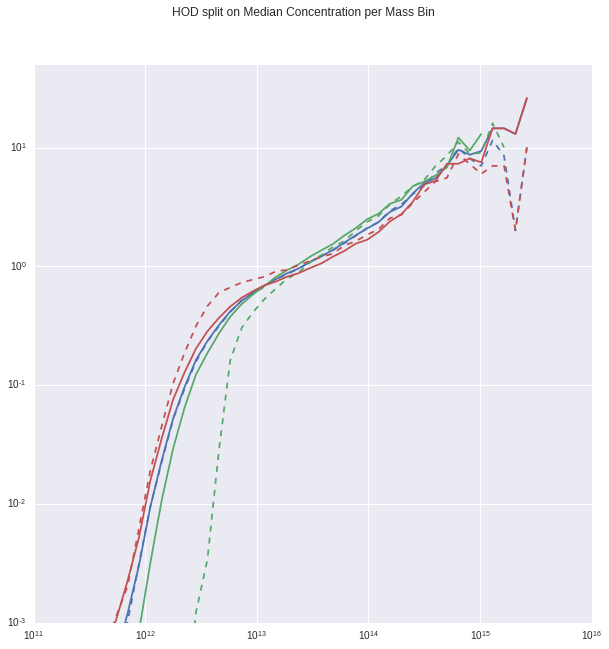

In [161]:
fig = plt.figure(figsize = (10,10))

for s, m, c,l in izip([cen_hod+sat_hod, low_cen_hod+low_sat_hod, high_cen_hod+high_sat_hod],\
                      [mock_cen_hod+mock_sat_hod, low_mock_cen_hod+low_mock_sat_hod, high_mock_cen_hod+high_mock_sat_hod],\
                      sns.color_palette(), ['All', 'Low', 'High']):

    plt.plot(mass_bin_centers,s, color = c, label = l)
    plt.plot(mass_bin_centers,m, ls = '--', color = c)

plt.loglog()
plt.ylim([1e-3,5e1])
plt.suptitle('HOD split on Median Concentration per Mass Bin')


plt.show()

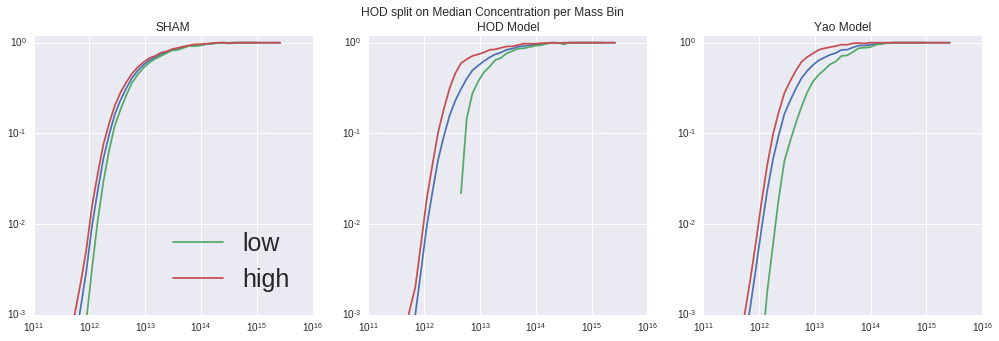

In [162]:
fig = plt.figure(figsize = (17,5))

plt.subplot(131)
plt.title('SHAM')
plt.plot(mass_bin_centers,cen_hod)
plt.plot(mass_bin_centers,low_cen_hod, label = 'low')
plt.plot(mass_bin_centers,high_cen_hod, label = 'high')

plt.legend(loc='best', fontsize = 25)
plt.loglog()
plt.ylim([1e-3,1.2])
plt.subplot(132)
plt.title('HOD Model')
plt.plot(mass_bin_centers,mock_cen_hod)
plt.plot(mass_bin_centers,low_mock_cen_hod, label = 'low')
plt.plot(mass_bin_centers,high_mock_cen_hod, label = 'high')
plt.loglog()
plt.ylim([1e-3,1.2])
plt.subplot(133)
plt.title('Yao Model')
plt.plot(mass_bin_centers,yao_cen_hod)
plt.plot(mass_bin_centers,low_yao_cen_hod, label = 'low')
plt.plot(mass_bin_centers,high_yao_cen_hod, label = 'high')
plt.loglog()
plt.ylim([1e-3,1.2])
plt.suptitle('HOD split on Median Concentration per Mass Bin')


plt.show()

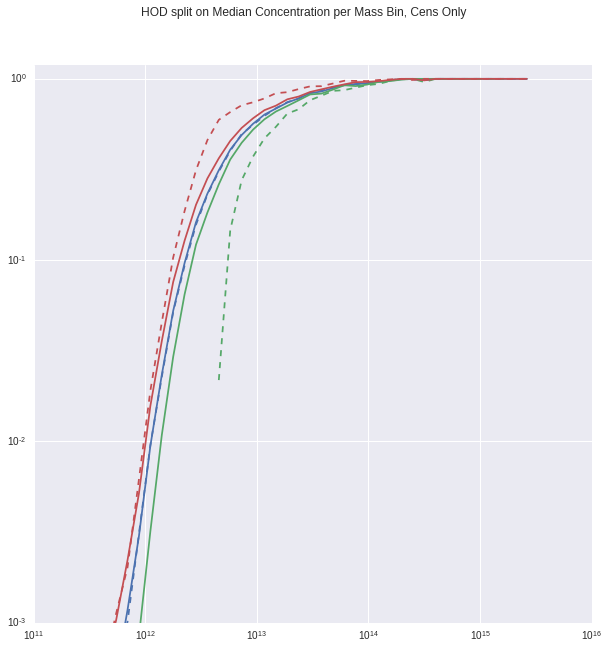

In [163]:
fig = plt.figure(figsize = (10,10))

for s, m, c,l in izip([cen_hod, low_cen_hod, high_cen_hod], [mock_cen_hod, low_mock_cen_hod, high_mock_cen_hod],\
                      sns.color_palette(), ['All', 'Low', 'High']):

    plt.plot(mass_bin_centers,s, color = c, label = l)
    plt.plot(mass_bin_centers,m, ls = '--', color = c)

plt.loglog()
plt.ylim([1e-3,1.2])
plt.suptitle('HOD split on Median Concentration per Mass Bin, Cens Only')


plt.show()

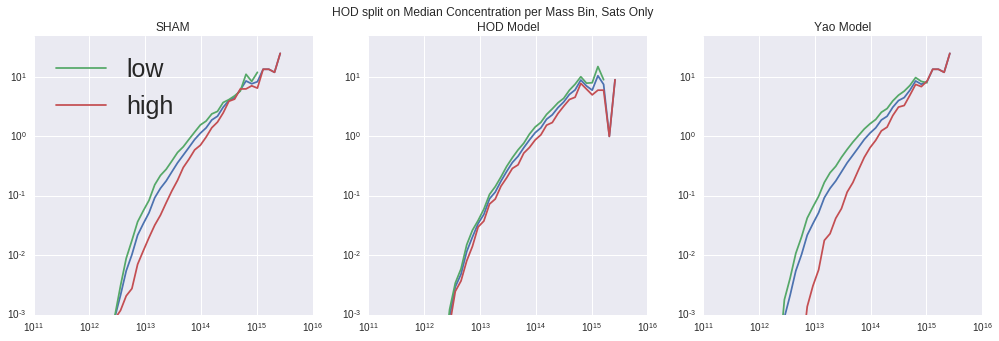

In [164]:
fig = plt.figure(figsize = (17,5))

plt.subplot(131)
plt.title('SHAM')
plt.plot(mass_bin_centers,sat_hod)
plt.plot(mass_bin_centers,low_sat_hod, label = 'low')
plt.plot(mass_bin_centers,high_sat_hod, label = 'high')

plt.legend(loc='best', fontsize = 25)
plt.loglog()
plt.ylim([1e-3,5e1])
plt.subplot(132)
plt.title('HOD Model')
plt.plot(mass_bin_centers,mock_sat_hod)
plt.plot(mass_bin_centers,low_mock_sat_hod, label = 'low')
plt.plot(mass_bin_centers,high_mock_sat_hod, label = 'high')
plt.loglog()
plt.ylim([1e-3,5e1])
plt.subplot(133)
plt.title('Yao Model')
plt.plot(mass_bin_centers,yao_sat_hod)
plt.plot(mass_bin_centers,low_yao_sat_hod, label = 'low')
plt.plot(mass_bin_centers,high_yao_sat_hod, label = 'high')
plt.loglog()
plt.ylim([1e-3,5e1])
plt.suptitle('HOD split on Median Concentration per Mass Bin, Sats Only')

plt.show()

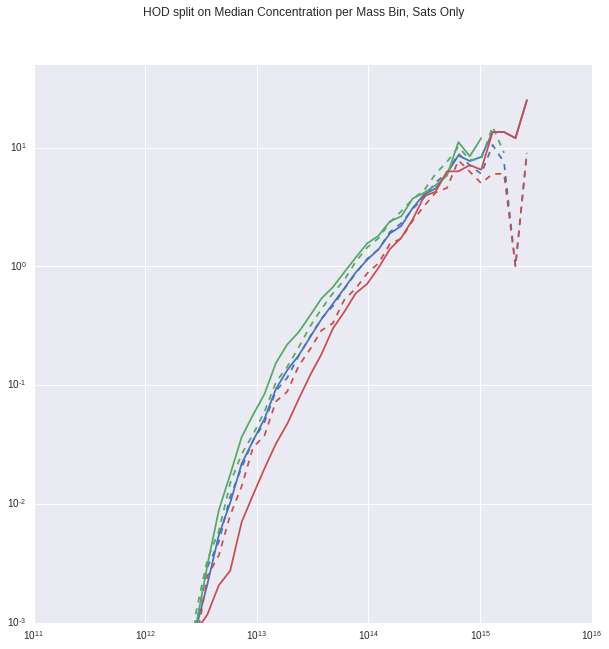

In [165]:
fig = plt.figure(figsize = (10,10))

for s, m, c,l in izip([sat_hod, low_sat_hod, high_sat_hod], [mock_sat_hod, low_mock_sat_hod, high_mock_sat_hod],\
                      sns.color_palette(), ['All', 'Low', 'High']):

    plt.plot(mass_bin_centers,s, color = c, label = l)
    plt.plot(mass_bin_centers,m, ls = '--', color = c)

plt.loglog()
plt.ylim([1e-3,5e1])
plt.suptitle('HOD split on Median Concentration per Mass Bin, Sats Only')


plt.show()

In [166]:
#rp_bins = np.logspace(-1,1.5,12)
rp_bins = np.logspace(-1,1.6,18)
bin_centers = (rp_bins[:1]+rp_bins[:-1])/2

In [167]:
from halotools.mock_observables import wp
from halotools.mock_observables import tpcf as xi

In [168]:
#mock_wp = cat.calc_wp(rp_bins, RSD= False)
mock_pos = np.c_[cat.model.mock.galaxy_table['x'][cat.model.mock.galaxy_table['gal_type']=='centrals']
                 ,cat.model.mock.galaxy_table['y'][cat.model.mock.galaxy_table['gal_type']=='centrals'],
                 cat.model.mock.galaxy_table['z'][cat.model.mock.galaxy_table['gal_type']=='centrals']]
#mock_wp = wp(mock_pos, rp_bins, 40.0 , period=cat.Lbox, num_threads=1)
mock_wp = xi(mock_pos, rp_bins, period=cat.Lbox, num_threads=1)

In [169]:
print np.log10(np.min(cat.model.mock.galaxy_table['halo_mvir']))
print np.log10(np.min(catalog[:,3]))
print np.log10(PMASS*200)

11.1335
11.0729847456
11.07292706


In [170]:
sham_pos = np.c_[halo_catalog['halo_x'][halo_catalog['halo_upid']==-1]
                 ,halo_catalog['halo_y'][halo_catalog['halo_upid']==-1],
                 halo_catalog['halo_z'][halo_catalog['halo_upid']==-1]]
#sham_wp = wp(sham_pos, rp_bins, 40.0 , period=cat.Lbox, num_threads=1)
sham_wp = xi(sham_pos, rp_bins, period=cat.Lbox, num_threads=1)

In [171]:
catalog.shape

(1628416, 6)

In [172]:
yao_gal_idxs = yao_cens>0
yao_pos = np.c_[halo_table[halo_table[upid_key]==-1]['halo_x'][yao_gal_idxs],
                halo_table[halo_table[upid_key]==-1]['halo_y'][yao_gal_idxs],
                halo_table[halo_table[upid_key]==-1]['halo_z'][yao_gal_idxs]]
#yao_wp = wp(yao_pos, rp_bins, 40.0 , period=cat.Lbox, num_threads=1)
yao_wp = xi(yao_pos, rp_bins, period=cat.Lbox, num_threads=1)

In [173]:
baseline_upper_bound = 1.0
baseline_lower_bound = 0.0
def percentile_perturbation(sec_haloprop, baseline_result, splitting_result):
    perturbation = np.zeros(len(sec_haloprop))
    sh_perc = rank_order_percentile(sec_haloprop)
    A = 1
    strength = noisy_percentile(sh_perc, correlation_coeff = A) -0.5
    positive_strength_idx = strength > 0
    negative_strength_idx = strength < 0

    if len(baseline_result[positive_strength_idx]) > 0:
        base_pos = baseline_result[positive_strength_idx]
        split_pos = splitting_result[positive_strength_idx]
        type1_frac_pos = 1 - split_pos
        strength_pos = strength[positive_strength_idx]

        upper_bound1 = baseline_upper_bound - base_pos
        upper_bound2 = ((1 - type1_frac_pos)/type1_frac_pos)*(base_pos - baseline_lower_bound)
        upper_bound = np.minimum(upper_bound1, upper_bound2)
        perturbation[positive_strength_idx] = strength_pos*upper_bound

    if len(baseline_result[negative_strength_idx]) > 0:
        base_neg = baseline_result[negative_strength_idx]
        split_neg = splitting_result[negative_strength_idx]
        type1_frac_neg = 1 - split_neg
        strength_neg = strength[negative_strength_idx]

        lower_bound1 = baseline_lower_bound - base_neg
        lower_bound2 = (1 - type1_frac_neg)/type1_frac_neg*(base_neg - baseline_upper_bound)
        lower_bound = np.maximum(lower_bound1, lower_bound2)
        perturbation[negative_strength_idx] = np.abs(strength_neg)*lower_bound

    return perturbation

In [174]:
prim_haloprop = cat.model.mock.halo_table['halo_mvir']
sec_haloprop = cat.model.mock.halo_table['halo_nfw_conc']

In [175]:
cen_occ = cat.model.model_dictionary['centrals_occupation']
split = cen_occ.percentile_splitting_function(prim_haloprop = prim_haloprop)

In [176]:
from halotools.utils import rank_order_percentile
from halotools.empirical_models import noisy_percentile

In [177]:
final_result_percentile = np.zeros_like(prim_haloprop)
mb_nos = compute_prim_haloprop_bins(prim_haloprop = catalog[:,3], prim_haloprop_bin_boundaries = mass_bins)

for i, (mb, ch, sh) in  enumerate(zip(np.unique(mb_nos), cen_hod, sat_hod)):
    idx_in_bin = np.where(mb_nos == mb)[0]
    rank_conc = get_ranks(catalog[idx_in_bin, 5])
    occ_in_bin = ch*np.ones_like(idx_in_bin)
    sec_haloprop_in_bin = sec_haloprop[idx_in_bin]
    final_result_percentile[idx_in_bin] = occ_in_bin+ percentile_perturbation(sec_haloprop_in_bin, occ_in_bin, split[idx_in_bin])

In [178]:
np_cens = np.random.binomial(n=1, p = final_result_percentile)

In [179]:
np_cen_hod,_ = compute_hod(prim_haloprop, np_cens, np.zeros_like(np_cens),  mass_bins)

In [ ]:
np_gal_idxs = np_cens>0
np_pos = np.c_[halo_table[halo_table[upid_key]==-1]['halo_x'][np_gal_idxs],
                halo_table[halo_table[upid_key]==-1]['halo_y'][np_gal_idxs],
                halo_table[halo_table[upid_key]==-1]['halo_z'][np_gal_idxs]]
#np_wp = wp(np_pos, rp_bins, 40.0 , period=cat.Lbox, num_threads=1)
np_wp = xi(np_pos, rp_bins, period=cat.Lbox, num_threads=1)

In [ ]:
catalog_ = astropy.table.Table.read('abmatched_halos.hdf5', format = 'hdf5')

In [ ]:
sh_halo_catalog = catalog_[np.logical_and(catalog_['halo_mvir'] > min_ptcl*cat.pmass, catalog_['halo_sh_shuffled_vpeak_mag'] <=mag_cut)]

In [ ]:
sham_shuffled_pos = np.c_[sh_halo_catalog['halo_shuffled_x'][sh_halo_catalog['halo_upid']==-1],\
                          sh_halo_catalog['halo_shuffled_y'][sh_halo_catalog['halo_upid']==-1],\
                          sh_halo_catalog['halo_shuffled_z'][sh_halo_catalog['halo_upid']==-1]]
#sham_shuffled_wp = wp(sham_shuffled_pos, rp_bins, 40.0 , period=cat.Lbox, num_threads=1)
sham_shuffled_wp = xi(sham_shuffled_pos, rp_bins , period=cat.Lbox, num_threads=1)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(bin_centers, mock_wp, label = 'model')
plt.plot(bin_centers, sham_wp, label = 'sham')
#plt.plot(bin_centers, sham_nfw_wp, label = 'nfw-ized sham')
plt.plot(bin_centers, sham_shuffled_wp, label = 'shuffled & nfw-ized sham')
plt.plot(bin_centers, yao_wp, label = 'Yao')

plt.loglog()
plt.legend(loc='best',fontsize = 15)
plt.xlim([5e-1, 5e0]);
#plt.ylim([1,1500])
plt.xlabel(r'$r_p$',fontsize = 15)
plt.ylabel(r'$w(r_p)$',fontsize = 15)
plt.title(r'$w(r_p)$ comparison for HOD+AB and NFW-ized SHAM', fontsize = 20)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(bin_centers, mock_wp/sham_shuffled_wp, label = 'model/shuffle')
plt.plot(bin_centers, sham_wp/sham_shuffled_wp, label = 'sham/shuffle')
#plt.plot(bin_centers, sham_nfw_wp/mock_wp, label = 'nfw-ized sham/model')
plt.plot(bin_centers, sham_shuffled_wp/sham_shuffled_wp, label = 'shuffled & nfw-ized sham/shuffle')
plt.plot(bin_centers, yao_wp/sham_shuffled_wp, label = 'yao/shuffle')

plt.xscale('log')
plt.legend(loc='best')
plt.xlim([5e-1, 1e1]);
plt.ylim([0.8,1.4]);
plt.xlabel(r'$r_p$',fontsize = 15)
plt.ylabel(r'$w_{SHAM}(r_p)/w_{HOD+AB}(r_p)$',fontsize = 15)
plt.title(r'$w(r_p)$ ratios', fontsize = 20)

In [566]:
conc_bins = np.linspace(0, 22, 10)#np.linspace(0, 1000, 10)#np.linspace(0, 22, 10)

In [567]:
from scipy.stats import binned_statistic

In [568]:
np.unique(mb_nos)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43])

In [569]:
mass_bins = compute_mass_bins(halo_table['halo_mvir'], 0.2)

mb_nos = compute_prim_haloprop_bins(prim_haloprop = catalog[:,3], prim_haloprop_bin_boundaries = mass_bins)


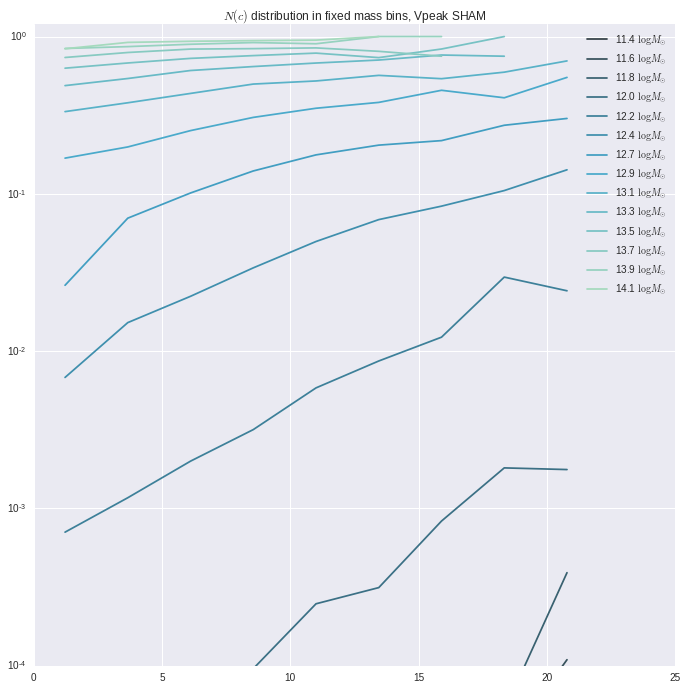

In [570]:
mass_bin_nos = range(1,15,1)
colors = sns.color_palette("GnBu_d", len(mass_bin_nos))
fig = plt.figure(figsize = ((11.5,11.5)))
for bin_no, c in zip(mass_bin_nos, colors):
    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mb_nos == bin_no)[0]
    cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])
    med_conc = np.median(catalog[indices_of_mb, 5])

    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 1],bins=conc_bins), \
                               binned_statistic(catalog[indices_of_mb,5], catalog[indices_of_mb, 2], bins = conc_bins)

    cen_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,1], bins = conc_bins, statistic='sum')
    sat_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],catalog[indices_of_mb,2], bins = conc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/50] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    #plt.subplot(121)
    #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    #plt.errorbar(c_bin_centers,(binned_sats-sats_avg), yerr=np.sqrt(binned_sats/sat_bin_counts),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
    plt.plot(c_bin_centers,(binned_cens),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))

    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    #plt.subplot(122)
    #plt.plot(c_bin_centers,binned_sats/sats_avg, color = c,lw=2.5)#, label = r"%.2f $M_{\odot}$"%bin_center)
    #plt.errorbar(c_bin_centers,(binned_sats/sats_avg), yerr=np.sqrt(binned_sats/(sats_avg*sat_bin_counts)),color = c)
    #plt.plot(c_bin_centers,(binned_sats),color = c)

    #plt.vlines(med_conc, -1, 1, color = c)
    
    
#plt.subplot(121)
#plt.xscale('log')
plt.title(r"$N(c)$, centrals")
plt.legend(loc='best')
#plt.xlim([0,25])
#plt.ylim([-0.2,1.2])
plt.ylim(1e-4, 1.2)
plt.yscale('log')
#plt.subplot(122)
#plt.title(r"$N(c)$, satellites")
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim([-0.2,1.2])
#plt.xlim([0,25])
plt.title(r"$N(c)$ distribution in fixed mass bins, Vpeak SHAM")
plt.show()

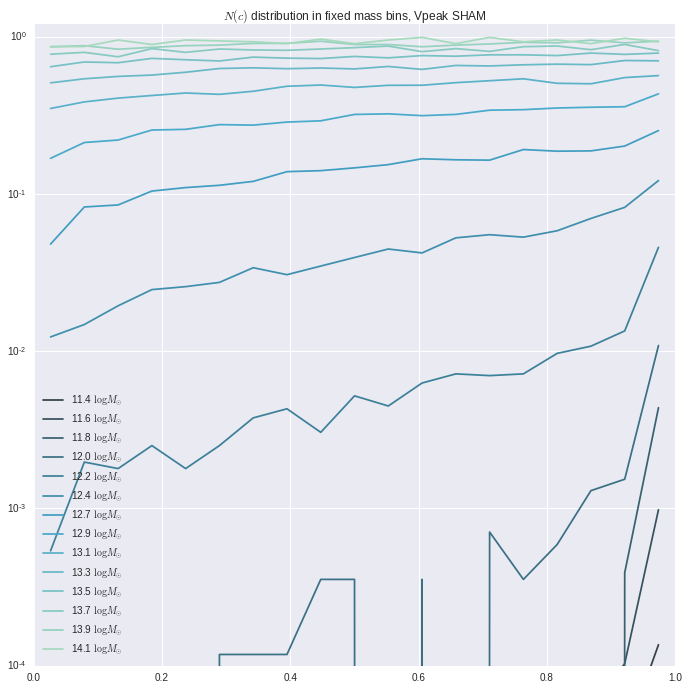

In [571]:
#mass_bin_nos = range(5,15,1)
fig = plt.figure(figsize = ((11.5,11.5)))
perc_bins = np.linspace(0, 1, 20)
for bin_no, c in zip(mass_bin_nos, colors):
    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mb_nos == bin_no)[0]
    cens_avg, sats_avg = np.mean(catalog[indices_of_mb, 1]), np.mean(catalog[indices_of_mb, 2])
    med_conc = np.median(catalog[indices_of_mb, 5])

    conc_rank = rankdata(catalog[indices_of_mb,5])/len(indices_of_mb)
    
    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(conc_rank, catalog[indices_of_mb, 1],bins=perc_bins), \
                               binned_statistic(conc_rank, catalog[indices_of_mb, 2], bins = perc_bins)

    cen_bin_counts, _, _ = binned_statistic(conc_rank,catalog[indices_of_mb,1], bins = perc_bins, statistic='sum')
    sat_bin_counts, _, _ = binned_statistic(conc_rank,catalog[indices_of_mb,2], bins = perc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/50] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    #plt.subplot(121)
    #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    #plt.errorbar(c_bin_centers,(binned_sats-sats_avg), yerr=np.sqrt(binned_sats/sat_bin_counts),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
    plt.plot(c_bin_centers,(binned_cens),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))

    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    #plt.subplot(122)
    #plt.plot(c_bin_centers,binned_sats/sats_avg, color = c,lw=2.5)#, label = r"%.2f $M_{\odot}$"%bin_center)
    #plt.errorbar(c_bin_centers,(binned_sats/sats_avg), yerr=np.sqrt(binned_sats/(sats_avg*sat_bin_counts)),color = c)
    #plt.plot(c_bin_centers,(binned_sats),color = c)

    #plt.vlines(med_conc, -1, 1, color = c)
    
    
#plt.subplot(121)
#plt.xscale('log')
plt.title(r"$N(c)$, centrals")
plt.legend(loc='best')
#plt.xlim([0,25])
#plt.ylim([-0.2,1.2])
plt.ylim(1e-4, 1.2)
plt.yscale('log')#plt.subplot(122)
#plt.title(r"$N(c)$, satellites")
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim([-0.2,1.2])
#plt.xlim([0,25])
plt.title(r"$N(c)$ distribution in fixed mass bins, Vpeak SHAM")
plt.show()

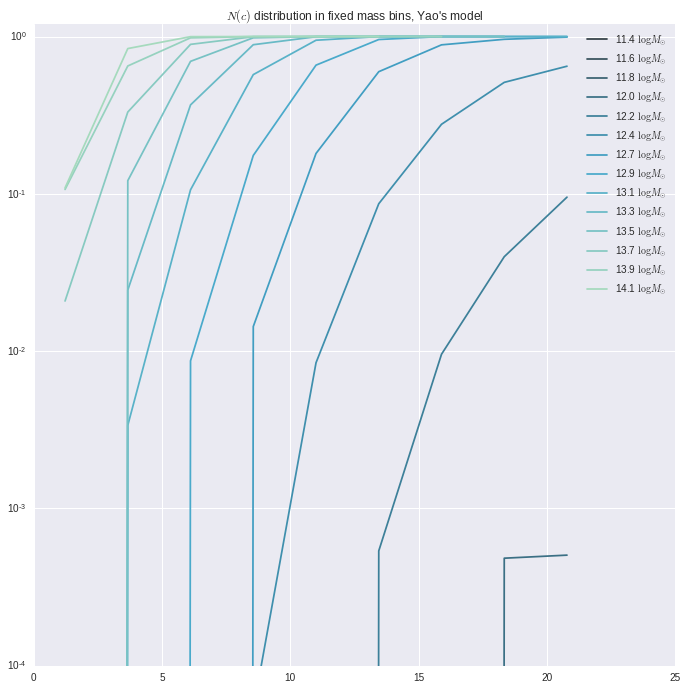

In [572]:
#mass_bin_nos = range(5,15,1)
fig = plt.figure(figsize = ((11.5,11.5)))
for bin_no, c in zip(mass_bin_nos, colors):
    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mb_nos == bin_no)[0]
    cens_avg, sats_avg = np.mean(yao_cens[indices_of_mb]), np.mean(yao_sats[indices_of_mb])
    med_conc = np.median(catalog[indices_of_mb, 5])

    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(catalog[indices_of_mb,5], yao_cens[indices_of_mb],bins=conc_bins), \
                               binned_statistic(catalog[indices_of_mb,5], yao_sats[indices_of_mb], bins = conc_bins)

    cen_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],yao_cens[indices_of_mb], bins = conc_bins, statistic='sum')
    sat_bin_counts, _, _ = binned_statistic(catalog[indices_of_mb,5],yao_sats[indices_of_mb], bins = conc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/50] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    #plt.subplot(121)
    #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    #plt.errorbar(c_bin_centers,(binned_sats-sats_avg), yerr=np.sqrt(binned_sats/sat_bin_counts),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
    plt.plot(c_bin_centers,(binned_cens),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))

    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    #plt.subplot(122)
    #plt.plot(c_bin_centers,binned_sats/sats_avg, color = c,lw=2.5)#, label = r"%.2f $M_{\odot}$"%bin_center)
    #plt.errorbar(c_bin_centers,(binned_sats/sats_avg), yerr=np.sqrt(binned_sats/(sats_avg*sat_bin_counts)),color = c)
    #plt.plot(c_bin_centers,(binned_sats),color = c)

    #plt.vlines(med_conc, -1, 1, color = c)
    
    
#plt.subplot(121)
#plt.xscale('log')
plt.title(r"$N(c)$, centrals")
plt.legend(loc='best')
#plt.xlim([0,25])
#plt.ylim([-0.2,1.2])
plt.ylim(1e-4, 1.2)
plt.yscale('log')#plt.subplot(122)
#plt.title(r"$N(c)$, satellites")
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim([-0.2,1.2])
#plt.xlim([0,25])
plt.title(r"$N(c)$ distribution in fixed mass bins, Yao's model")
plt.show()

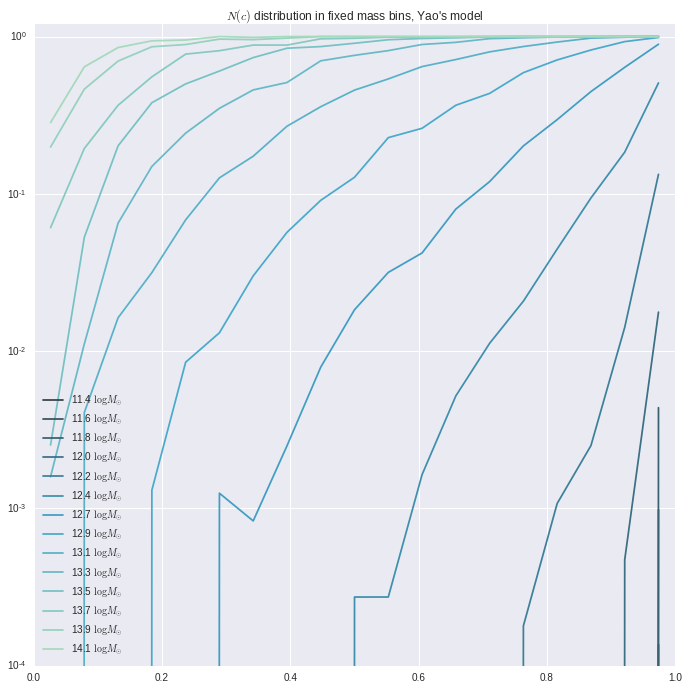

In [573]:
#mass_bin_nos = range(5,15,1)
fig = plt.figure(figsize = ((11.5,11.5)))
for bin_no, c in zip(mass_bin_nos, colors):
    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mb_nos == bin_no)[0]
    cens_avg, sats_avg = np.mean(yao_cens[indices_of_mb]), np.mean(yao_sats[indices_of_mb])
    med_conc = np.median(catalog[indices_of_mb, 5])
    
    conc_rank = rankdata(catalog[indices_of_mb,5])/len(indices_of_mb)

    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(conc_rank, yao_cens[indices_of_mb],bins=perc_bins), \
                               binned_statistic(conc_rank, yao_sats[indices_of_mb], bins = perc_bins)

    cen_bin_counts, _, _ = binned_statistic(conc_rank,yao_cens[indices_of_mb], bins = conc_bins, statistic='sum')
    sat_bin_counts, _, _ = binned_statistic(conc_rank,yao_sats[indices_of_mb], bins = conc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/50] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    #plt.subplot(121)
    #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    #plt.errorbar(c_bin_centers,(binned_sats-sats_avg), yerr=np.sqrt(binned_sats/sat_bin_counts),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
    plt.plot(c_bin_centers,(binned_cens),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))

    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    #plt.subplot(122)
    #plt.plot(c_bin_centers,binned_sats/sats_avg, color = c,lw=2.5)#, label = r"%.2f $M_{\odot}$"%bin_center)
    #plt.errorbar(c_bin_centers,(binned_sats/sats_avg), yerr=np.sqrt(binned_sats/(sats_avg*sat_bin_counts)),color = c)
    #plt.plot(c_bin_centers,(binned_sats),color = c)

    #plt.vlines(med_conc, -1, 1, color = c)
    
    
#plt.subplot(121)
#plt.xscale('log')
plt.title(r"$N(c)$, centrals")
plt.legend(loc='best')
#plt.xlim([0,25])
#plt.ylim([-0.2,1.2])
plt.ylim(1e-4, 1.2)
plt.yscale('log')#plt.subplot(122)
#plt.title(r"$N(c)$, satellites")
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim([-0.2,1.2])
#plt.xlim([0,25])
plt.title(r"$N(c)$ distribution in fixed mass bins, Yao's model")
plt.show()

In [574]:
mock_concentrations = cat.model.mock.halo_table['halo_nfw_conc']
#mock_concentrations = cat.model.mock.halo_table['halo_vpeak']

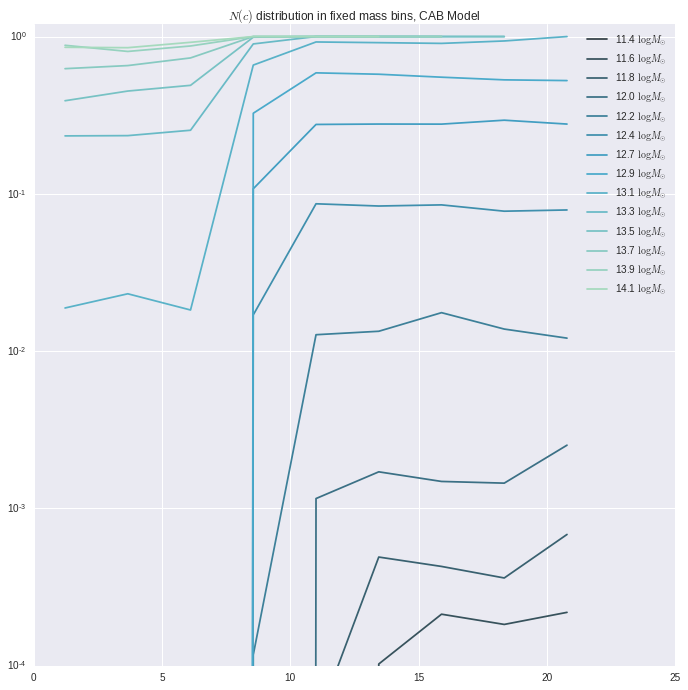

In [575]:
#mass_bin_nos = range(5,15,1)
fig = plt.figure(figsize = ((11.5,11.5)))
for bin_no, c in zip(mass_bin_nos, colors):
    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mb_nos == bin_no)[0]
    cens_avg, sats_avg = np.mean(mock_centrals[indices_of_mb]), np.mean(mock_satellites[indices_of_mb])
    med_conc = np.median(catalog[indices_of_mb, 5])

    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(mock_concentrations[indices_of_mb], mock_centrals[indices_of_mb],bins=conc_bins), \
                               binned_statistic(mock_concentrations[indices_of_mb], mock_satellites[indices_of_mb], bins = conc_bins)

    cen_bin_counts, _, _ = binned_statistic(mock_concentrations[indices_of_mb], mock_centrals[indices_of_mb], bins = conc_bins, statistic='sum')
    sat_bin_counts, _, _ = binned_statistic(mock_concentrations[indices_of_mb], mock_satellites[indices_of_mb], bins = conc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/50] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    #plt.subplot(121)
    #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    #plt.errorbar(c_bin_centers,(binned_sats-sats_avg), yerr=np.sqrt(binned_sats/sat_bin_counts),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
    plt.plot(c_bin_centers,(binned_cens),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))

    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    #plt.subplot(122)
    #plt.plot(c_bin_centers,binned_sats/sats_avg, color = c,lw=2.5)#, label = r"%.2f $M_{\odot}$"%bin_center)
    #plt.errorbar(c_bin_centers,(binned_sats/sats_avg), yerr=np.sqrt(binned_sats/(sats_avg*sat_bin_counts)),color = c)
    #plt.plot(c_bin_centers,(binned_cens),color = c)
    #plt.plot(c_bin_centers,(binned_sats),color = c)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    
#plt.subplot(121)
#plt.xscale('log')
plt.title(r"$N(c)$, centrals")
plt.legend(loc='best')
#plt.xlim([0,25])
#plt.ylim([-0.2,1.2])
plt.ylim(1e-4, 1.2)
plt.yscale('log')#plt.subplot(122)
#plt.title(r"$N(c)$, satellites")
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim([-0.2,1.2])
#plt.xlim([0,25])
plt.title(r"$N(c)$ distribution in fixed mass bins, CAB Model")
plt.show()

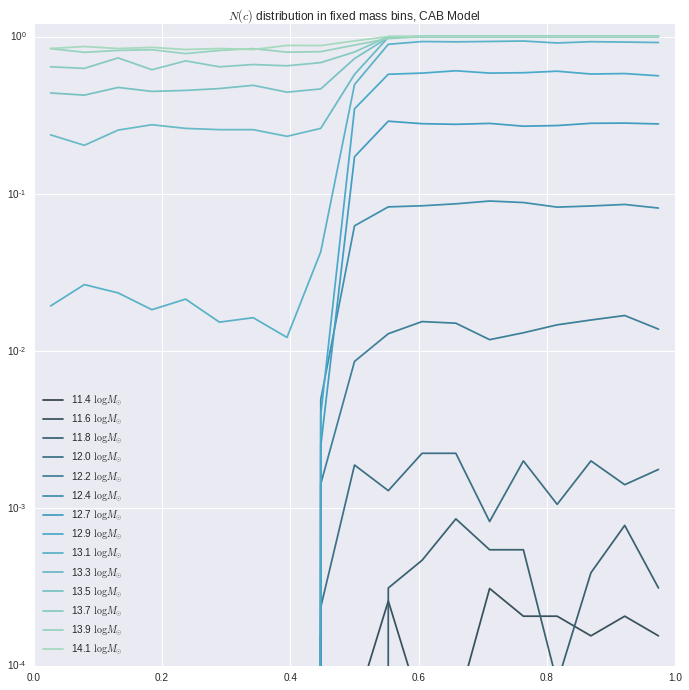

In [576]:
#mass_bin_nos = range(5,15,1)
fig = plt.figure(figsize = ((11.5,11.5)))
for bin_no, c in zip(mass_bin_nos, colors):
    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mb_nos == bin_no)[0]
    cens_avg, sats_avg = np.mean(mock_centrals[indices_of_mb]), np.mean(mock_satellites[indices_of_mb])
    med_conc = np.median(catalog[indices_of_mb, 5])
    
    conc_rank = rankdata(mock_concentrations[indices_of_mb])/len(indices_of_mb)

    (binned_cens, c_bins,_), (binned_sats,_,_) = binned_statistic(conc_rank, mock_centrals[indices_of_mb],bins=perc_bins), \
                               binned_statistic(conc_rank, mock_satellites[indices_of_mb], bins = perc_bins)

    cen_bin_counts, _, _ = binned_statistic(conc_rank, mock_centrals[indices_of_mb], bins = conc_bins, statistic='sum')
    sat_bin_counts, _, _ = binned_statistic(conc_rank, mock_satellites[indices_of_mb], bins = conc_bins, statistic='sum')
    #binned_sats[sat_bin_counts < len(indices_of_mb)/50] = sats_avg

    c_bin_centers = (c_bins[1:]+c_bins[:-1])/2
    #plt.subplot(121)
    #plt.plot(c_bin_centers,(binned_sats-sats_avg), color = c,lw=2.5, label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center) )
    #plt.errorbar(c_bin_centers,(binned_sats-sats_avg), yerr=np.sqrt(binned_sats/sat_bin_counts),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))
    plt.plot(c_bin_centers,(binned_cens),color = c,label = r"%.1f $\log M_{\odot}$"%np.log10(bin_center))

    #plt.hist(catalog[indices_of_mb,5], bins = conc_bins, color = c, alpha = 0.3, normed=True)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    #plt.subplot(122)
    #plt.plot(c_bin_centers,binned_sats/sats_avg, color = c,lw=2.5)#, label = r"%.2f $M_{\odot}$"%bin_center)
    #plt.errorbar(c_bin_centers,(binned_sats/sats_avg), yerr=np.sqrt(binned_sats/(sats_avg*sat_bin_counts)),color = c)
    #plt.plot(c_bin_centers,(binned_cens),color = c)
    #plt.plot(c_bin_centers,(binned_sats),color = c)
    #plt.vlines(med_conc, -1, 1, color = c)
    
    
#plt.subplot(121)
#plt.xscale('log')
plt.title(r"$N(c)$, centrals")
plt.legend(loc='best')
#plt.xlim([0,25])
#plt.ylim([-0.2,1.2])
plt.ylim(1e-4, 1.2)
plt.yscale('log')#plt.subplot(122)
#plt.title(r"$N(c)$, satellites")
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim([-0.2,1.2])
#plt.xlim([0,25])
plt.title(r"$N(c)$ distribution in fixed mass bins, CAB Model")
plt.show()

In [577]:
mass_bins = compute_mass_bins(halo_table['halo_mvir'], 0.1)

mb_nos = compute_prim_haloprop_bins(prim_haloprop = catalog[:,3], prim_haloprop_bin_boundaries = mass_bins)

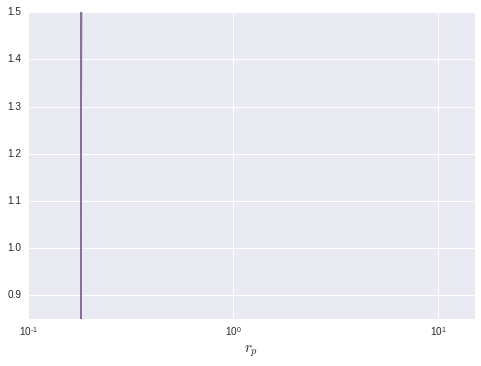

In [578]:
for i in xrange(10):
    _yao_cens = np.zeros_like(cens_occ)
    _yao_sats = np.zeros_like(sats_occ)
    mb_nos = compute_prim_haloprop_bins(prim_haloprop = catalog[:,3], prim_haloprop_bin_boundaries = mass_bins)

    for i, (mb, ch, sh) in  enumerate(zip(np.unique(mb_nos), cen_hod, sat_hod)):
        idx_in_bin = np.where(mb_nos == mb)[0]
        rank_conc = get_ranks(catalog[idx_in_bin, 5])
        _yao_cens[idx_in_bin] = 1.0-get_cen_count(rank_conc, ch, -1.0)
        _yao_sats[idx_in_bin] = get_sat_count(rank_conc, sh, -1.0)

    yao_gal_idxs = _yao_cens>0

    yao_pos = np.c_[halo_table[halo_table[upid_key]==-1]['halo_x'][yao_gal_idxs],
                    halo_table[halo_table[upid_key]==-1]['halo_y'][yao_gal_idxs],
                    halo_table[halo_table[upid_key]==-1]['halo_z'][yao_gal_idxs]]
    yao_wp = wp(yao_pos, rp_bins, 40.0 , period=cat.Lbox, num_threads=1)
    
    #plt.plot(bin_centers, yao_wp/sham_shuffled_wp)
    plt.plot(bin_centers, yao_wp/sham_shuffled_wp)

    
plt.xscale('log')
plt.xlim([1e-1, 15e0]);
plt.ylim([0.85,1.5]);
plt.xlabel(r'$r_p$',fontsize = 15)
plt.show();

In [579]:
#MAP = np.array([ 1.0, -1,5,5])
names = ['mean_occupation_centrals_assembias_param1','mean_occupation_satellites_assembias_param1',\
        'mean_occupation_centrals_assembias_slope1','mean_occupation_satellites_assembias_slope1']
params = dict(zip(names, MAP))

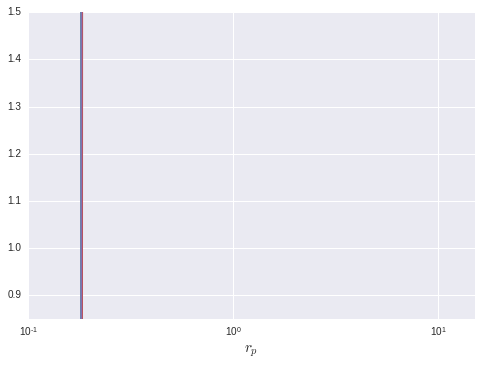

In [580]:
for i in xrange(10):
    cat.populate(params)
    mock_pos = np.c_[cat.model.mock.galaxy_table['x'][cat.model.mock.galaxy_table['gal_type']=='centrals']
                 ,cat.model.mock.galaxy_table['y'][cat.model.mock.galaxy_table['gal_type']=='centrals'],
                 cat.model.mock.galaxy_table['z'][cat.model.mock.galaxy_table['gal_type']=='centrals']]
    mock_wp = wp(mock_pos, rp_bins, 40.0 , period=cat.Lbox, num_threads=1)
    
    #plt.plot(bin_centers, yao_wp/sham_shuffled_wp)
    plt.plot(bin_centers, mock_wp/sham_shuffled_wp)

    
plt.xscale('log')
plt.xlim([1e-1, 15e0]);
plt.ylim([0.85,1.5]);
plt.xlabel(r'$r_p$',fontsize = 15)
plt.show();

In [581]:
np.sum(mock_centrals)

0

In [582]:
mock_centrals =cat.model.mock.halo_table['halo_num_centrals']

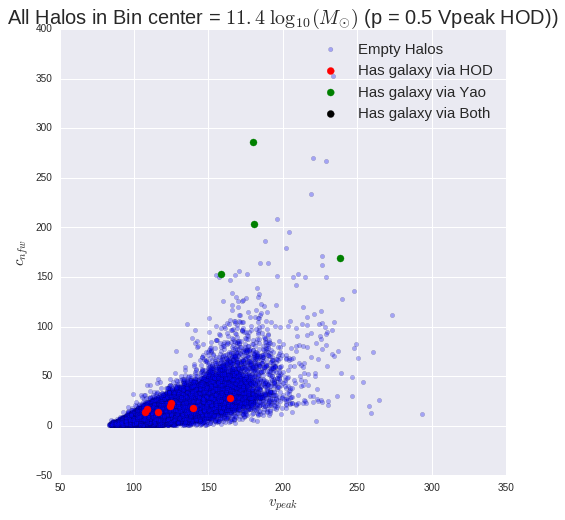

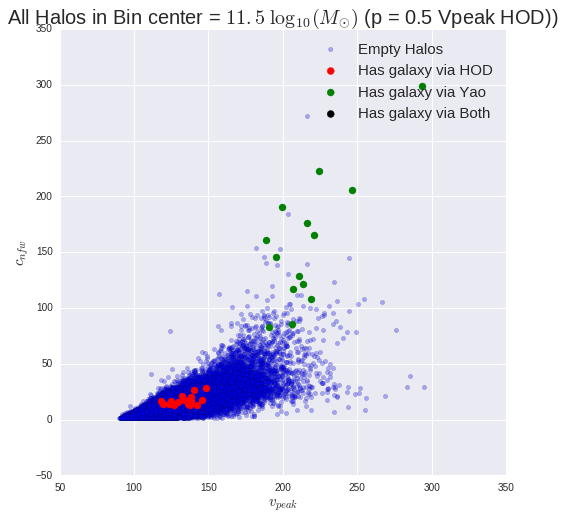

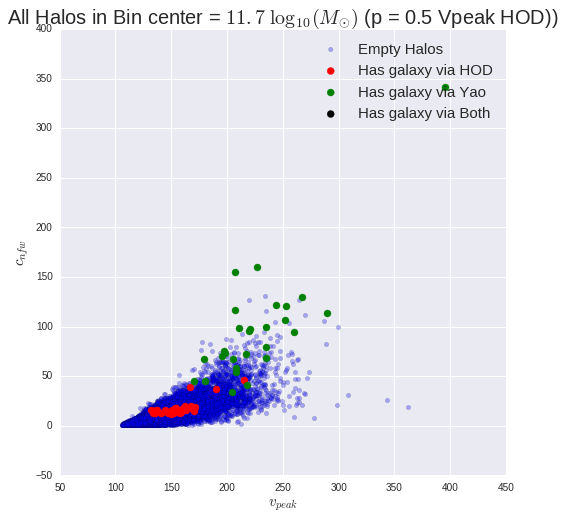

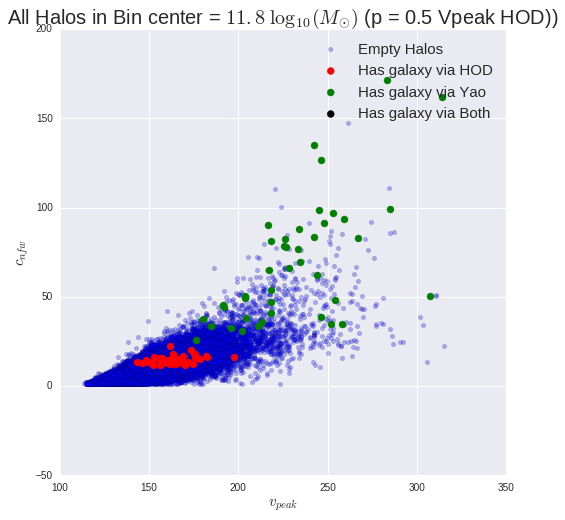

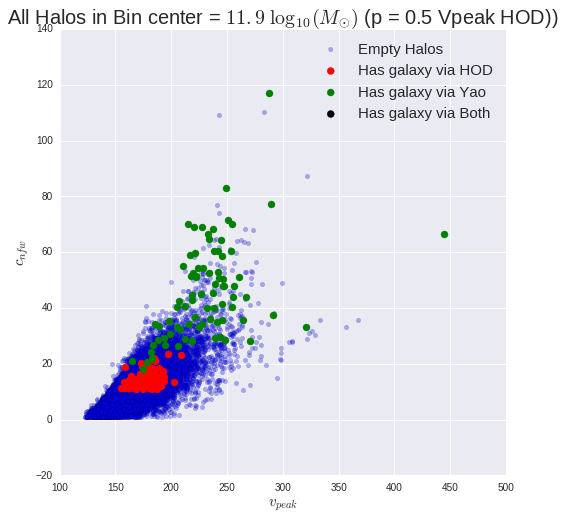

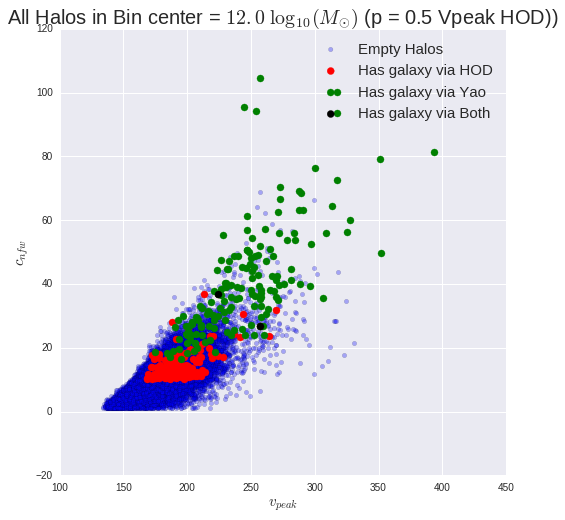

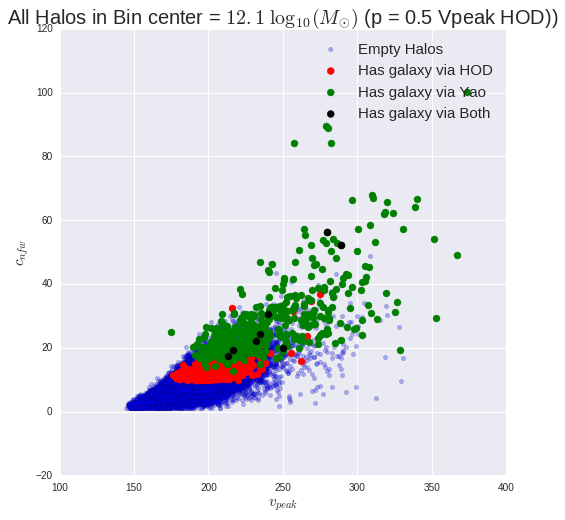

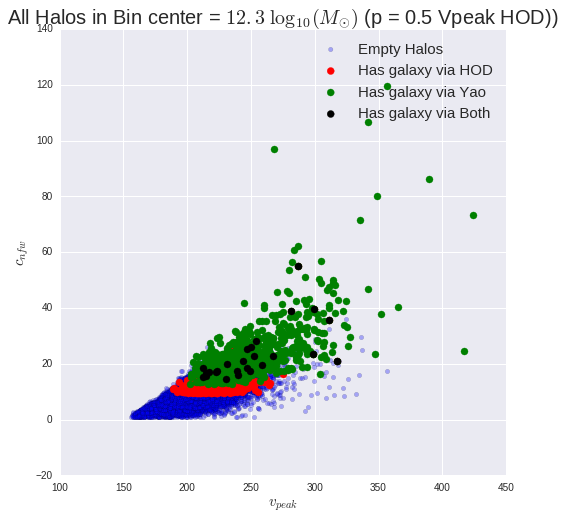

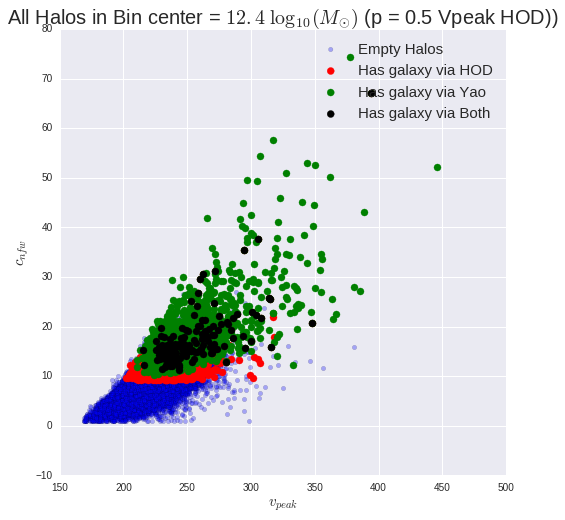

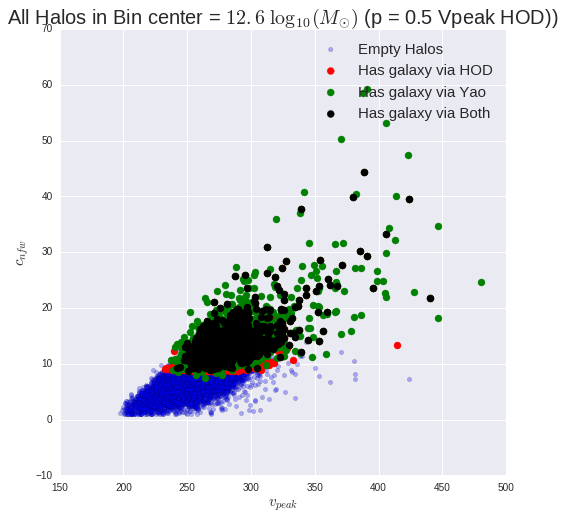

In [583]:
for bin_no in mass_bin_nos:
    #if bin_no < 2 or bin_no >15:
    #    continue
    fig = plt.figure(figsize = ((8,8)))

    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mb_nos == bin_no)[0]
    
    plt.scatter(halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_vpeak'],\
                    halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_nfw_conc'],\
                    alpha = 0.3, label = 'Empty Halos')
    
    in_hod = np.where(mock_centrals[indices_of_mb]==1)[0]
    in_yao = np.where(yao_cens[indices_of_mb]==1)[0]
    
    #print np.min(halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_yao]['halo_nfw_conc']),
    #print np.min(halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_hod]['halo_nfw_conc'])

    #print np.percentile(halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_nfw_conc'], [50, 75, 80,85,90,95,99, 99.9])
    
    plt.scatter(halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_hod]['halo_vpeak'],\
                    halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_hod]['halo_nfw_conc'],\
                    color = 'r',s=50, label = 'Has galaxy via HOD')
    plt.scatter(halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_yao]['halo_vpeak'],\
                    halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_yao]['halo_nfw_conc'],\
                    color = 'g',s=50, label = 'Has galaxy via Yao')
    in_both = np.intersect1d(in_yao, in_hod)
    plt.scatter(halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_both]['halo_vpeak'],\
                    halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_both]['halo_nfw_conc'],\
                    color = 'k',s=50, label = 'Has galaxy via Both')
    
    plt.title(r'All Halos in Bin center = $%.1f\; \log_{10}({M_{\odot}})$ (p = 0.5 Vpeak HOD))'%np.log10(bin_center), fontsize = 20)
    
    plt.xlabel(r"$v_{peak}$", fontsize = 15)
    plt.ylabel(r"$c_{nfw}$", fontsize = 15)
    plt.legend(loc='best', fontsize = 15)

    plt.show()

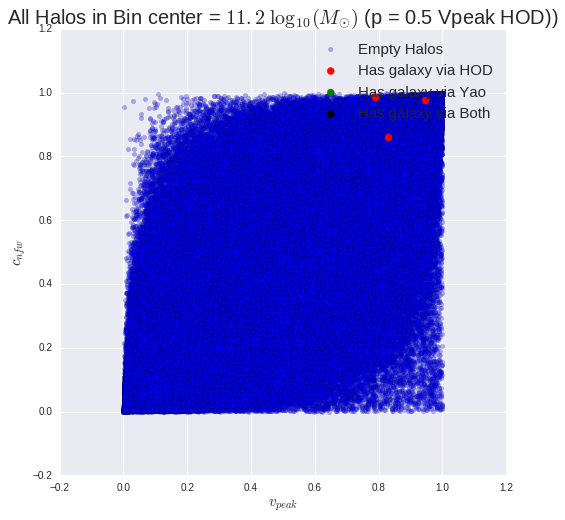

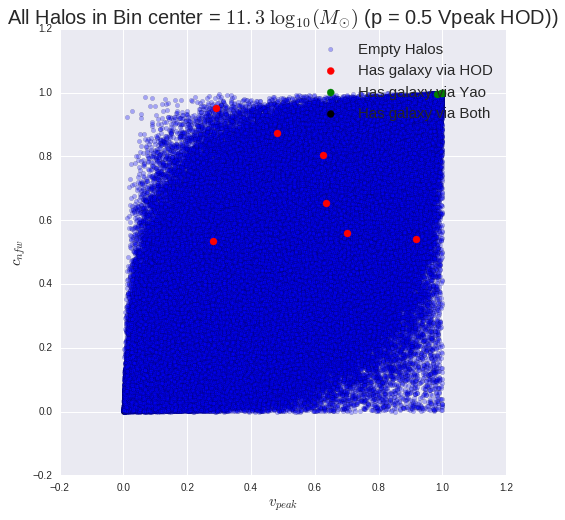

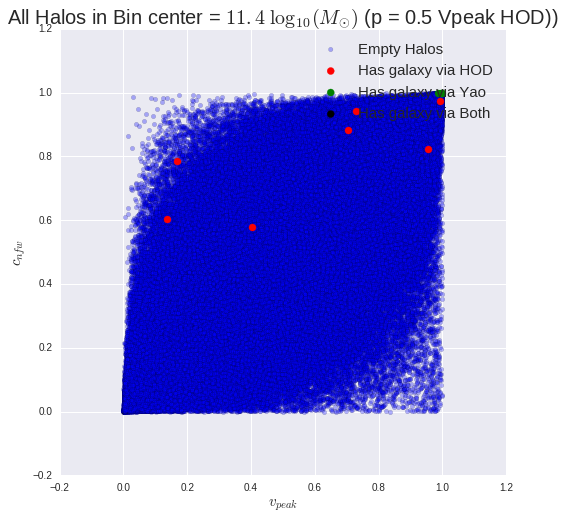

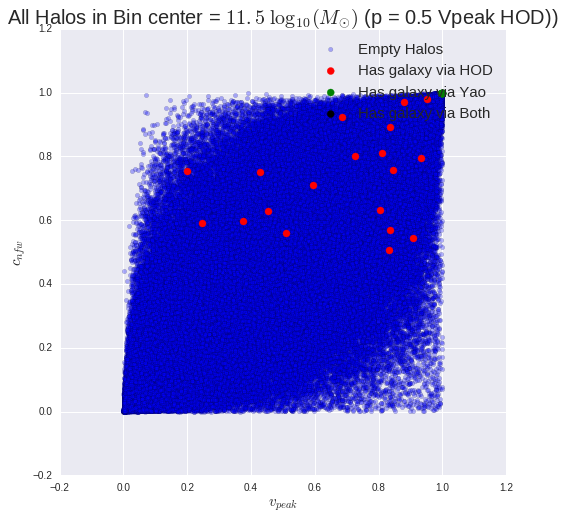

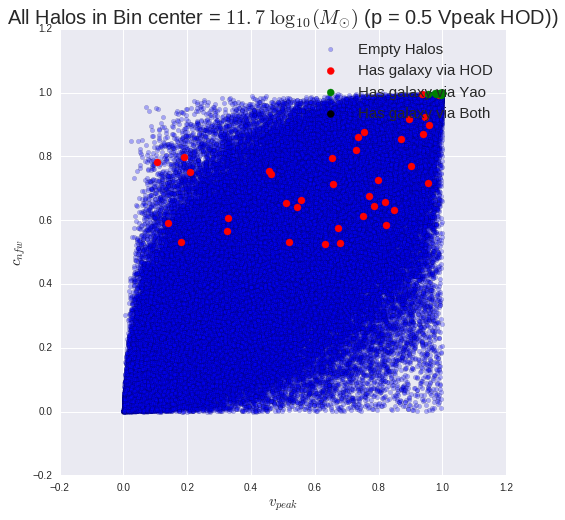

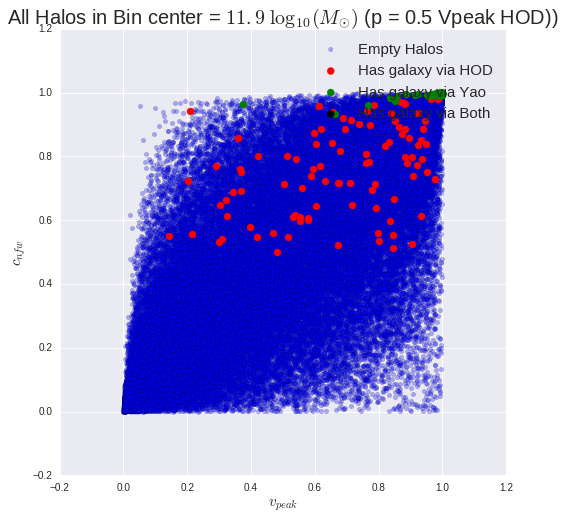

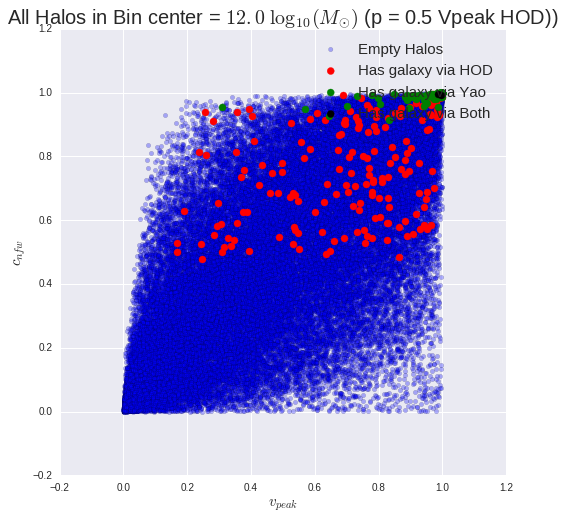

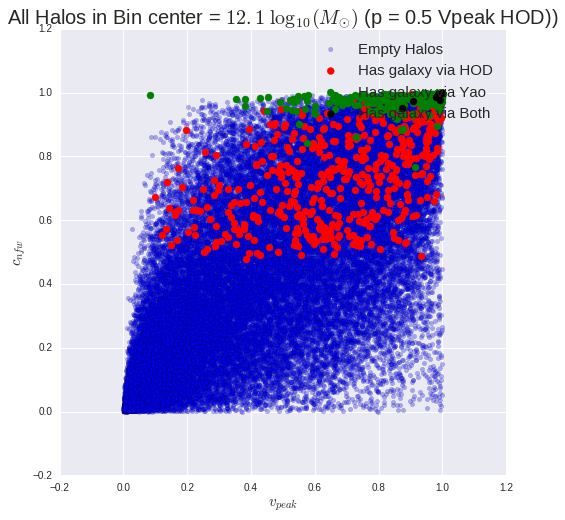

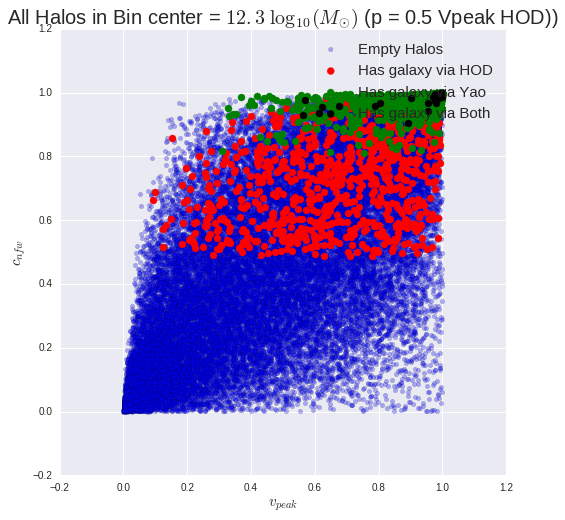

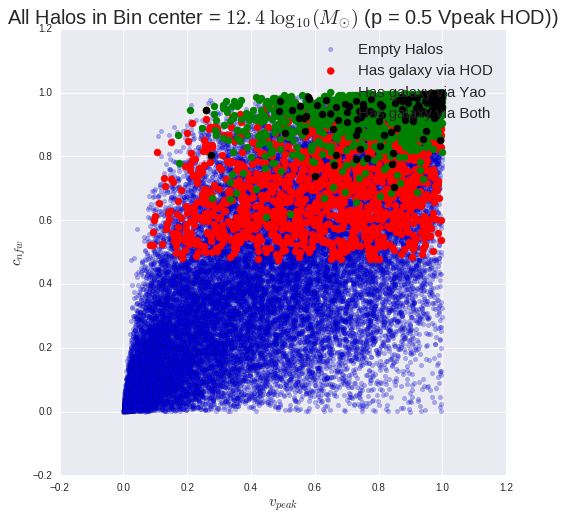

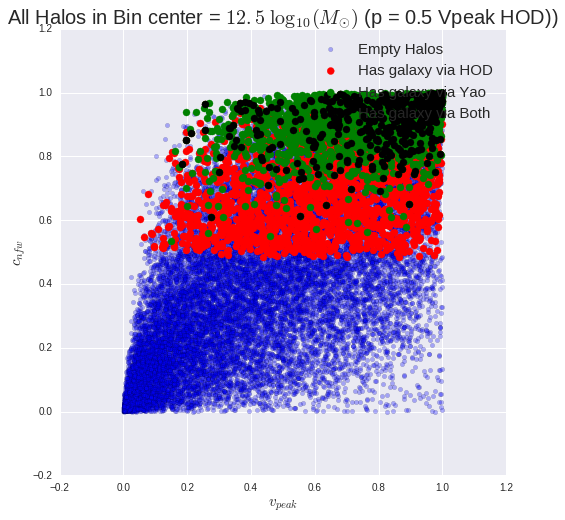

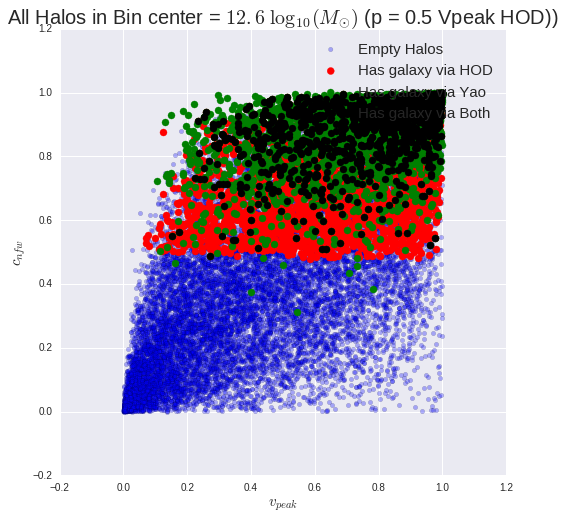

In [584]:
for bin_no in mass_bin_nos:
    #if bin_no < 2 or bin_no >15:
    #    continue
    fig = plt.figure(figsize = ((8,8)))

    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mb_nos == bin_no)[0]
    
    vpeak_rank = rankdata(halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_vpeak'])/len(indices_of_mb)
    conc_rank = rankdata(halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_nfw_conc'])/len(indices_of_mb)

    
    plt.scatter(vpeak_rank,\
                    conc_rank,\
                    alpha = 0.3, label = 'Empty Halos')
    
    in_hod = np.where(mock_centrals[indices_of_mb]==1)[0]
    in_yao = np.where(yao_cens[indices_of_mb]==1)[0]
    
    #print np.min(halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_yao]['halo_nfw_conc']),
    #print np.min(halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_hod]['halo_nfw_conc'])

    #print np.percentile(halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_nfw_conc'], [50, 75, 80,85,90,95,99, 99.9])
    
    plt.scatter(vpeak_rank[in_hod],\
                    conc_rank[in_hod],\
                    color = 'r',s=50, label = 'Has galaxy via HOD')
    plt.scatter(vpeak_rank[in_yao],\
                    conc_rank[in_yao],\
                    color = 'g',s=50, label = 'Has galaxy via Yao')
    in_both = np.intersect1d(in_yao, in_hod)
    plt.scatter(vpeak_rank[in_both],\
                    conc_rank[in_both],\
                    color = 'k',s=50, label = 'Has galaxy via Both')
    
    plt.title(r'All Halos in Bin center = $%.1f\; \log_{10}({M_{\odot}})$ (p = 0.5 Vpeak HOD))'%np.log10(bin_center), fontsize = 20)
    
    plt.xlabel(r"$v_{peak}$", fontsize = 15)
    plt.ylabel(r"$c_{nfw}$", fontsize = 15)
    plt.legend(loc='best', fontsize = 15)

    plt.show()

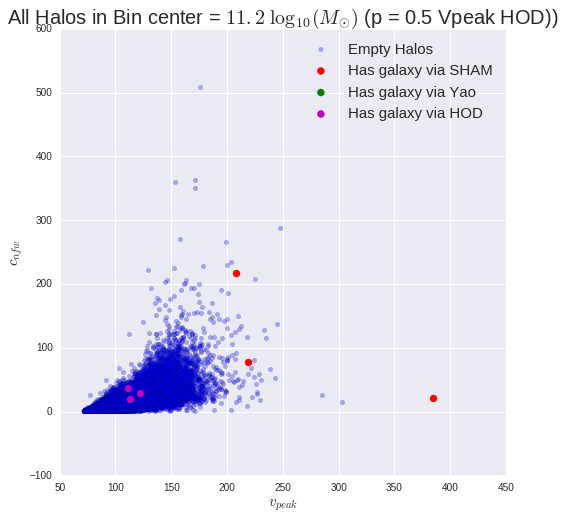

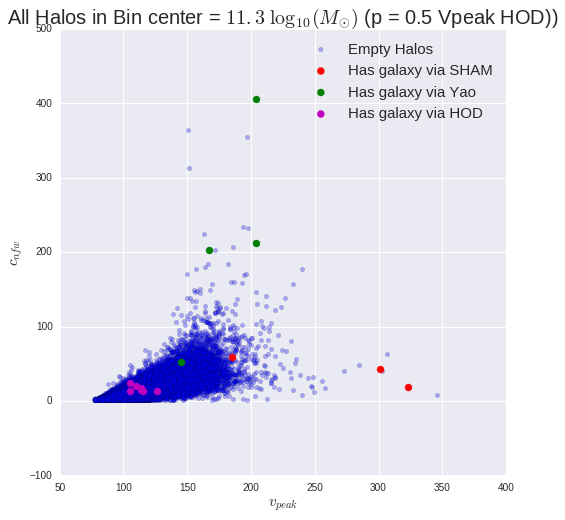

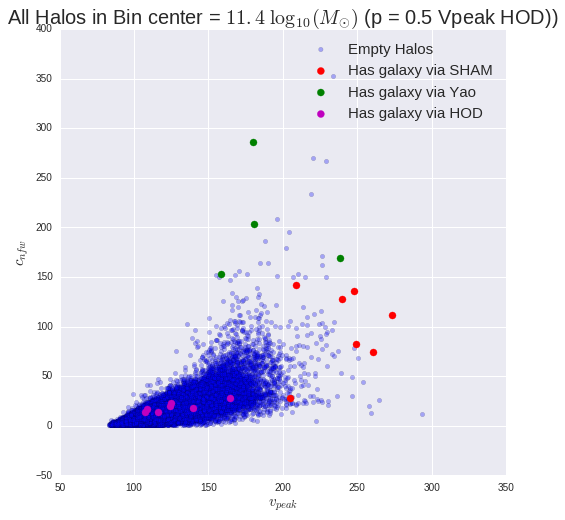

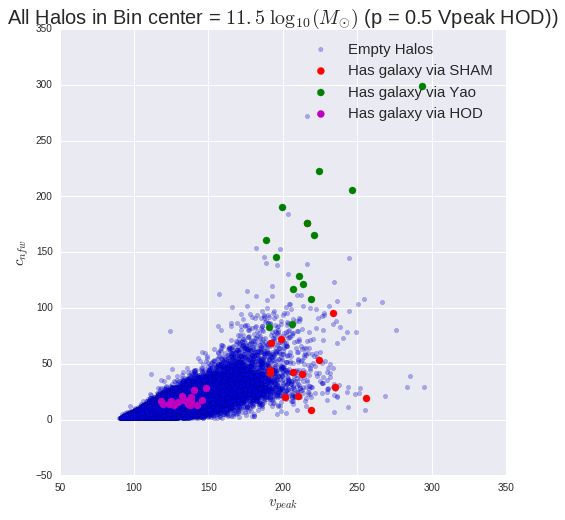

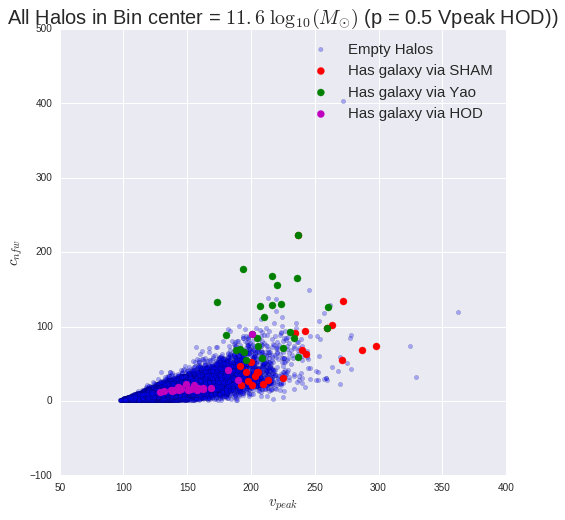

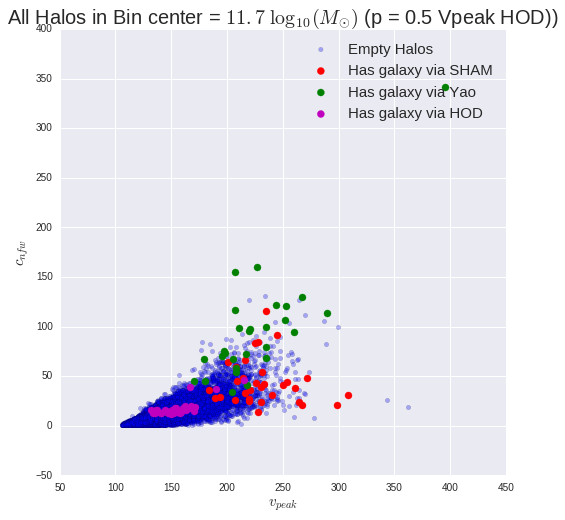

KeyboardInterrupt: 

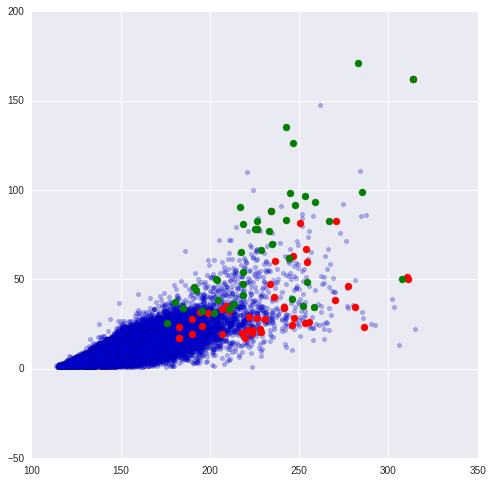

In [585]:
for bin_no in mass_bin_nos:
    #if bin_no < 2 or bin_no >15:
    #    continue
    fig = plt.figure(figsize = ((8,8)))

    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mb_nos == bin_no)[0]
    
    plt.scatter(halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_vpeak'],\
                    halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_nfw_conc'],\
                    alpha = 0.3, label = 'Empty Halos')
    
    in_sham = np.where(catalog[indices_of_mb,1]==1)[0]
    in_hod = np.where(mock_centrals[indices_of_mb]==1)[0]

    in_yao = np.where(yao_cens[indices_of_mb]==1)[0]
    
    plt.scatter(halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_sham]['halo_vpeak'],\
                    halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_sham]['halo_nfw_conc'],\
                    color = 'r',s=50, label = 'Has galaxy via SHAM')
    plt.scatter(halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_yao]['halo_vpeak'],\
                    halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_yao]['halo_nfw_conc'],\
                    color = 'g',s=50, label = 'Has galaxy via Yao')
    plt.scatter(halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_hod]['halo_vpeak'],\
                    halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_hod]['halo_nfw_conc'],\
                    color = 'm',s=50, label = 'Has galaxy via HOD')
    in_both = np.intersect1d(in_yao, in_hod)
    #plt.scatter(halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_both]['halo_vpeak'],\
    #                halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_both]['halo_nfw_conc'],\
    #                color = 'k',s=50, label = 'Has galaxy via Both')
    
    plt.title(r'All Halos in Bin center = $%.1f\; \log_{10}({M_{\odot}})$ (p = 0.5 Vpeak HOD))'%np.log10(bin_center), fontsize = 20)
    
    plt.xlabel(r"$v_{peak}$", fontsize = 15)
    plt.ylabel(r"$c_{nfw}$", fontsize = 15)
    plt.legend(loc='best', fontsize = 15)

    plt.show()

In [ ]:
for bin_no in mass_bin_nos:
    #if bin_no < 2 or bin_no >15:
    #    continue
    fig = plt.figure(figsize = ((8,8)))

    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mb_nos == bin_no)[0]
    
    vpeak_rank = rankdata(halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_vpeak'])/len(indices_of_mb)
    conc_rank = rankdata(halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_nfw_conc'])/len(indices_of_mb)

    
    plt.scatter(vpeak_rank,\
                    conc_rank,\
                    alpha = 0.3, label = 'Empty Halos')
    
    in_sham = np.where(catalog[indices_of_mb,1]==1)[0]
    in_hod = np.where(mock_centrals[indices_of_mb]==1)[0]

    in_yao = np.where(yao_cens[indices_of_mb]==1)[0]
    
    #print np.min(halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_yao]['halo_nfw_conc']),
    #print np.min(halo_table[halo_table['halo_upid']==-1][indices_of_mb][in_hod]['halo_nfw_conc'])

    #print np.percentile(halo_table[halo_table['halo_upid']==-1][indices_of_mb]['halo_nfw_conc'], [50, 75, 80,85,90,95,99, 99.9])
    
    plt.scatter(vpeak_rank[in_sham],\
                    conc_rank[in_sham],\
                    color = 'r',s=50, label = 'Has galaxy via SHAM')
    plt.scatter(vpeak_rank[in_yao],\
                    conc_rank[in_yao],\
                    color = 'g',s=50, label = 'Has galaxy via Yao')
    plt.scatter(vpeak_rank[in_hod],\
                    conc_rank[in_hod],\
                    color = 'm',s=50, label = 'Has galaxy via HOD')
    #in_both = np.intersect1d(in_yao, in_hod)
    #plt.scatter(vpeak_rank[in_both],\
    #                conc_rank[in_both],\
     #               color = 'k',s=50, label = 'Has galaxy via Both')
    
    plt.title(r'All Halos in Bin center = $%.1f\; \log_{10}({M_{\odot}})$ (p = 0.5 Vpeak HOD))'%np.log10(bin_center), fontsize = 20)
    
    plt.xlabel(r"$v_{peak}$", fontsize = 15)
    plt.ylabel(r"$c_{nfw}$", fontsize = 15)
    plt.legend(loc='best', fontsize = 15)

    plt.show()

In [ ]:
hod_perc = compute_conditional_percentiles(prim_haloprop = mock_masses, sec_haloprop = mock_centrals,
                                              prim_haloprop_bin_boundaries= mass_bins)

yao_perc = compute_conditional_percentiles(prim_haloprop = catalog[:,3], sec_haloprop = yao_cens,
                                              prim_haloprop_bin_boundaries= mass_bins)

In [ ]:
mass_bin_nos = np.unique(mb_nos)
for bin_no in mass_bin_nos:
    #if bin_no < 2 or bin_no >15:
    #    continue
    fig = plt.figure(figsize = ((17,8)))

    bin_center = np.mean(mass_bins[bin_no:bin_no+2])
    indices_of_mb = np.where(mb_nos == bin_no)[0]
    
    in_hod = np.where(mock_centrals[indices_of_mb]==1)[0]
    in_yao = np.where(yao_cens[indices_of_mb]==1)[0]

    plt.subplot(121)
    plt.scatter(percentiles[indices_of_mb],
                hod_perc[indices_of_mb],\
                    color = 'r',s=50, label = 'HOD', alpha = 0.2)
    
    plt.scatter(percentiles[indices_of_mb][in_hod],
                hod_perc[indices_of_mb][in_hod],\
                   color = 'k',s=50, alpha = 0.2)
     
    plt.subplot(122)   
    plt.scatter(percentiles[indices_of_mb],
                yao_perc[indices_of_mb],\
                    color = 'g',s=50, label = 'Yao', alpha = 0.2)
    
    plt.scatter(percentiles[indices_of_mb][in_yao],
                yao_perc[indices_of_mb][in_yao],\
                    color = 'k',s=50, alpha = 0.2)
    

    plt.suptitle(r'All Halos in Bin center = $%.1f\; \log_{10}({M_{\odot}})$ (p = 0.5 Vpeak HOD))'%np.log10(bin_center), fontsize = 20)
    
    #plt.xlabel(r"$v_{peak}$", fontsize = 15)
    #plt.ylabel(r"$c_{nfw}$", fontsize = 15)
    plt.legend(loc='best', fontsize = 15)
    plt.subplot(121)
    plt.legend(loc='best', fontsize = 15)


    plt.show()